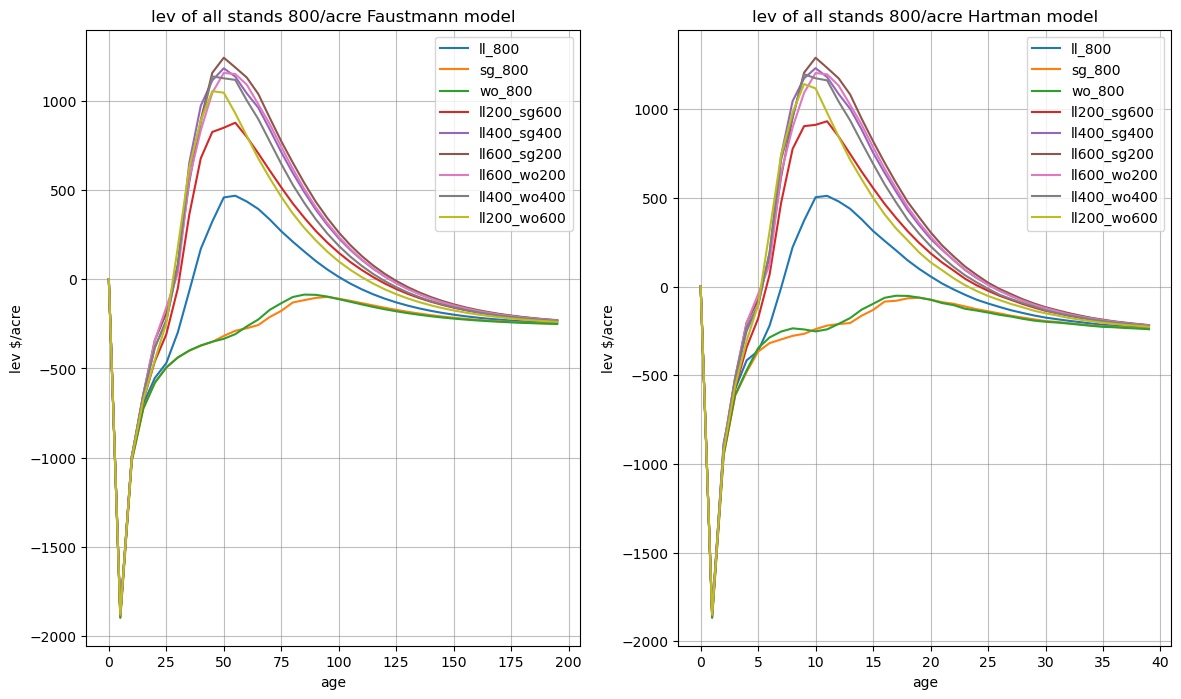

In [26]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def faustmann(revenue, age, cost, interest):
    if age:
        revenue = (revenue - (cost * interest ** age)) / ((interest ** age) - 1)
        return revenue
    else:
        return 0

def hartman(revenue, age, carbon, cost, interest):
    if age:
        revenue = (revenue - (cost * interest ** age) + carbon) / ((interest ** age) - 1)
        return revenue
    else:
        return 0

    
#carbon_price = 3
#ll_timber = 0.72
#ll_pulp = 0.27
#hw_timber = 23.25/35.31467
#hw_pulp = 9.78/35.31467
    
ll_800 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/800LL.csv", delimiter = ";")
sg_800 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/800SG.csv", delimiter = ";")
wo_800 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/800WO.csv", delimiter = ";")
ll200_sg600 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/200LL_600SG.csv", delimiter = ";")
ll400_sg400 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/400LL_400SG.csv", delimiter = ";")
ll600_sg200 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/600LL_200SG.csv", delimiter = ";")
ll600_wo200 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/600LL_200WO.csv", delimiter = ";")
ll400_wo400 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/400LL_400WO.csv", delimiter = ";")
ll200_wo600 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/200LL_600WO.csv", delimiter = ";")

stands = [ll_800, sg_800, wo_800, ll200_sg600, ll400_sg400, ll600_sg200, ll600_wo200, ll400_wo400, ll200_wo600] 
stands_sg = [ll_800, ll600_sg200, ll400_sg400, ll200_sg600, sg_800]
stands_wo = [ll_800, ll600_wo200, ll400_wo400, ll200_wo600, wo_800]
  
stand_dict = {"ll_800" : ll_800, "sg_800" : sg_800, "wo_800" : wo_800, "ll200_sg600" : ll200_sg600, "ll400_sg400" : ll400_sg400, "ll600_sg200" : ll600_sg200, "ll600_wo200" : ll600_wo200, "ll400_wo400" : ll400_wo400, "ll200_wo600" : ll200_wo600}

def lev(graphtitle, ll_timber, ll_pulp, hw_timber, hw_pulp, carbon_price, cost, interest, dict):  
    for label, stand in dict.items():
        stand_list = list(stand)
        stand.insert(loc=1, column="age", value=[i for i in range(0, 200, 5)])
        if len(stand_list) > 7:
            stand["ll_pulp"] = stand.iloc[:,3] - stand.iloc[:,6]
            stand["hw_pulp"] = stand.iloc[:,4] - stand.iloc[:,7]
            stand["revenue"] = stand.iloc[:,6] * ll_timber + stand.iloc[:,6] * hw_timber + stand.iloc[:,8] * ll_pulp + stand.iloc[:,9] * hw_pulp
            
        else:
            stand["pulp"] = stand.iloc[:,3] - stand.iloc[:,5]
            if stand.iloc[3,2] == 0:
                stand["revenue"] = stand.iloc[:,5] * hw_timber + stand.iloc[:,6] * hw_pulp
            else:
                stand["revenue"] = stand.iloc[:,5] * ll_timber + stand.iloc[:,6] * ll_pulp
                
        stand["faustmann"] = stand[["revenue", "age"]].apply(lambda x: faustmann(x["revenue"], x["age"], cost, interest), axis=1)
            
        stand["carbon_added"] = stand["Total_Stand_Carbon"].sub(stand["Total_Stand_Carbon"].shift(fill_value=0))
        stand["carbon_return"] = stand["carbon_added"] * carbon_price

        stand["carbon_annual"] = (stand['carbon_return'].expanding().apply(lambda x: sum(stand.loc[:x.index[-1], 'age'] * interest**(x.iloc[-1]-x))))

        stand["hartman"] = stand[["revenue", "age", "carbon_annual"]].apply(lambda x: hartman(x["revenue"], x["age"], x["carbon_annual"], cost, interest), axis=1)
        
        plt.figure(1, figsize = [14, 8])
        ax1 = plt.subplot(121)
        plt.plot(stand["age"], stand["faustmann"], label=label)
        plt.xlabel("age")
        plt.ylabel("lev $/acre")
        plt.title(graphtitle + " Faustmann model")
        plt.legend()
        ax1.grid(color="grey", alpha = 0.5)
        ax2 = plt.subplot(122)
        plt.plot(stand["hartman"], label=label)
        plt.xlabel("age")
        plt.ylabel("lev $/acre")
        plt.title(graphtitle + " Hartman model")
        plt.legend()
        ax2.grid(color="grey", alpha = 0.5)
        


lev("lev of all stands 800/acre", 0.72, 0.27, 23.25/35.31467, 0.1, 3, 262, 1.03, stand_dict)
#print(ll_800.head)


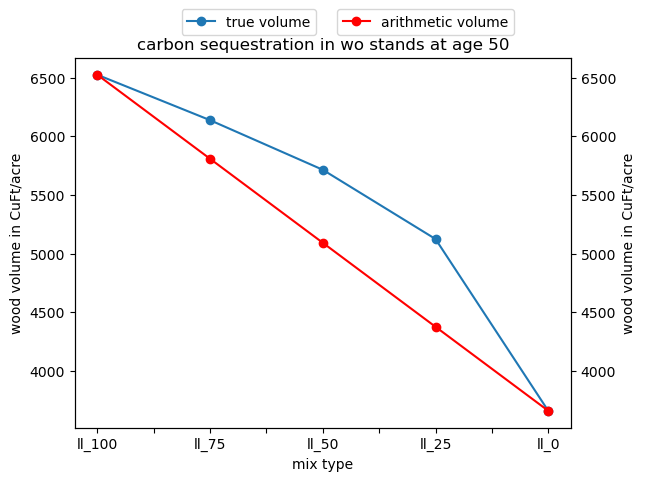

In [24]:
def wood_volume(graphtitle, age, *args):
    volume_true = []
    volume_arithmetic = []
    for stand in args:
        volume_true.append(stand.loc[stand["age"] == age]["Total_MCuFt"].item())
        
    volume_arithmetic.append(volume_true[0])
    volume_arithmetic.append(volume_true[0] * 0.75 + volume_true[-1] * 0.25)
    volume_arithmetic.append(volume_true[0] * 0.5 + volume_true[-1] * 0.5)   
    volume_arithmetic.append(volume_true[0] * 0.25 + volume_true[-1] * 0.75)
    volume_arithmetic.append(volume_true[-1])
    
    stand_df = pd.DataFrame()
    stand_df["mix type"] = ["ll_100", "ll_75", "ll_50", "ll_25", "ll_0"]
    stand_df["true volume"] = volume_true
    stand_df["arithmetic volume"] = volume_arithmetic
    vol_comp = stand_df.plot(x="mix type", y="true volume", marker = "o")
    plt.legend(bbox_to_anchor =(0.50, 1.15), ncol = 2)
    plt.ylabel("wood volume in CuFt/acre")
    vol_comp2 = vol_comp.twinx()
    stand_df.plot(x="mix type", y="arithmetic volume", ax=vol_comp2, marker = "o", color="r")
    plt.legend(bbox_to_anchor =(0.90, 1.15), ncol = 2)
    plt.title(graphtitle + " at age " + str(age))
    plt.ylabel("wood volume in CuFt/acre")
    
wood_volume("carbon sequestration in wo stands", 50, *stands_wo)

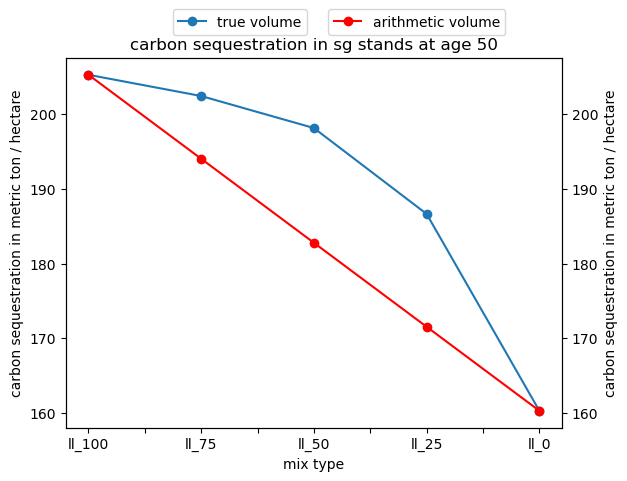

In [21]:
def carbon_volume(graphtitle, age, *args):
    volume_true = []
    volume_arithmetic = []
    for stand in args:
        volume_true.append(stand.loc[stand["age"] == age]["Total_Stand_Carbon"].item())
        
    volume_arithmetic.append(volume_true[0])
    volume_arithmetic.append(volume_true[0] * 0.75 + volume_true[-1] * 0.25)
    volume_arithmetic.append(volume_true[0] * 0.5 + volume_true[-1] * 0.5)   
    volume_arithmetic.append(volume_true[0] * 0.25 + volume_true[-1] * 0.75)
    volume_arithmetic.append(volume_true[-1])
    
    stand_df = pd.DataFrame()
    stand_df["mix type"] = ["ll_100", "ll_75", "ll_50", "ll_25", "ll_0"]
    stand_df["true volume"] = volume_true
    stand_df["arithmetic volume"] = volume_arithmetic
    vol_comp = stand_df.plot(x="mix type", y="true volume", marker = "o")
    plt.legend(bbox_to_anchor =(0.50, 1.15), ncol = 2)
    plt.ylabel("carbon sequestration in metric ton / hectare")
    vol_comp2 = vol_comp.twinx()
    stand_df.plot(x="mix type", y="arithmetic volume", ax=vol_comp2, marker = "o", color="r")
    plt.legend(bbox_to_anchor =(0.90, 1.15), ncol = 2)
    plt.title(graphtitle + " at age " + str(age))
    plt.ylabel("carbon sequestration in metric ton / hectare")

carbon_volume("carbon sequestration in sg stands", 50, *stands_sg)